## Import Liberaries

In [1]:
import tensorflow as tf
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_t3w8y4r
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_t3w8y4r
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173744 sha256=ab9371542b289c383e1fcc1120306b6f6b359fdacd337576e67cf4055d506d18
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbo_brqk/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Load MNIST Dataset

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


مقدار پیکسل‌های تصویر نرمال می‌شوند تا در بازه 1- تا 1+ قرار گیرند. 

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  

به تعداد 60000 تصویر از مجموعه داده به صورت تصادفی انتخاب شده و اندازه بچ برابر 256 قرار داده می‌شود

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build Generator 

در این مرحله مدل مولد ساخته می‌شود. ورودی این مدل یک بردار تصادفی 100 بعدی است. می‌خواهیم از این بردار 100 بعدی به یک تصویر (1, 28 , 28) برسیم. ابتدا یک کاملا متصل ایجاد کرده و آن را به یک بردار با ابعاد (256, 7 , 7) تبدیل می‌کنیم. سپس طی چندین مرحله و با استفاده از کانولوشن ترنسپوز دو بعدی آپ سمپلینگ انجام داده و خروجی را ارتقا می‌دهیم و به ترتیب از (256, 7 , 7) به (128, 7 , 7)  سپس (64, 14 , 14)  و درنهایت (1, 28 , 28) می‌رسیم

In [7]:
# # noise = tf.random.normal([1, 100])
# # input_gen = layers.Dense(7*7*256, use_bias=False, input_shape=(100,))(noise)
# # bn1_gen = layers.BatchNormalization()(input_gen)
# # lr1_gen = layers.LeakyReLU()(bn1_gen)
# # reshape_gen = layers.Reshape((7, 7, 256))(lr1_gen)
# # print(reshape_gen.shape)
# num_class = 10
# input_label = layers.Input(shape=(1,))
# cls = layers.Embedding(num_class, 50)(input_label)
# cls = layers.Dense(7 * 7)(cls)
# cls = layers.Reshape((7, 7, 1))(cls)


# input_gen = layers.Input(shape=(100,))
# gen = layers.Dense(7*7*256, use_bias=False)(input_gen)
# gen = layers.BatchNormalization()(gen)
# gen = layers.LeakyReLU()(gen)
# gen = layers.Reshape((7, 7, 256))(gen)
# print(gen.shape)
# assert gen.shape == (None, 7, 7, 256)  # Note: None is the batch size

# merge = layers.Concatenate()([gen, cls])
# gen = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(merge)
# gen.shape

In [8]:
def make_generator_model():
    num_class = 10
    input_label = layers.Input(shape=(1,))
    cls = layers.Embedding(num_class, 50)(input_label)
    cls = layers.Dense(7 * 7)(cls)
    cls = layers.Reshape((7, 7, 1))(cls)


    input_gen = layers.Input(shape=(100,))
    gen = layers.Dense(7*7*256, use_bias=False)(input_gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    gen = layers.Reshape((7, 7, 256))(gen)
    # assert gen.shape == (None, 7, 7, 256)  # Note: None is the batch size

    merge = layers.Concatenate()([gen, cls])

    gen = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(merge)
    # assert gen.shape == (None, 7, 7, 128)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)

    gen = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    # assert gen.shape == (None, 14, 14, 64)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)

    output_gen = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(gen)
    # assert output_gen.shape == (None, 28, 28, 1)
    model = tf.keras.Model([input_gen, input_label], output_gen)
    return model

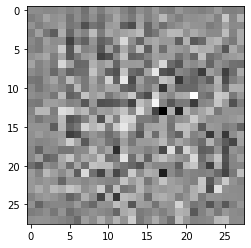

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
label = np.random.randint(0, 10, 1)
generated_image = generator([noise,label], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Build Discriminator

در این مرحله شبکه ممیز ساخته می‌شود که تصویر اصلی و جعلی را می‌گیرد و جعلی یا اصلی بودن آن را تشخیص دهد.

In [14]:
def make_discriminator_model():
    num_class = 10
    input_label = layers.Input(shape=(1,))
    cls = layers.Embedding(num_class, 50)(input_label)
    cls = layers.Dense(28 * 28)(cls)
    cls = layers.Reshape((28, 28, 1))(cls)

    input_disc = layers.Input(shape=(28,28,1))
    merge = layers.Concatenate()([input_disc, cls])
    disc = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merge)
    disc = layers.LeakyReLU()(disc)
    disc = layers.Dropout(0.3)(disc)

    disc = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(disc)
    disc = layers.LeakyReLU()(disc)
    disc = layers.Dropout(0.3)(disc)
    

    disc = layers.Flatten()(disc)
    output_disc = layers.Dense(1)(disc)


    model = tf.keras.Model([input_disc, input_label], output_disc)
    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator([generated_image, label])
print (decision)

tf.Tensor([[0.00254435]], shape=(1, 1), dtype=float32)


## Define Losses

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

تابع ضرر برای شبکه ممیز به صورت زیر تعریف می‌شود و پارماترهای شبکه ممیز طبق این تابع ضرر آپدیت می‌شوند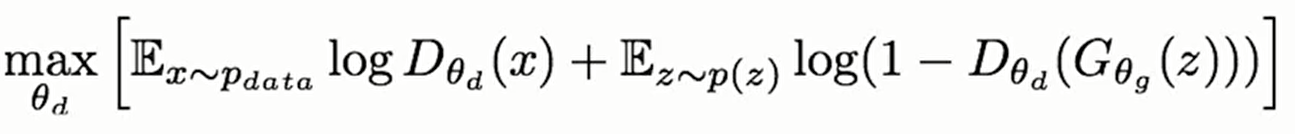

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

تابع ضرر برای شبکه مولد به صورت زیر محاسبه می‌شود و پارامترهای شبکه مولد مطابق این تابع ضرر آپدیت می‌شوند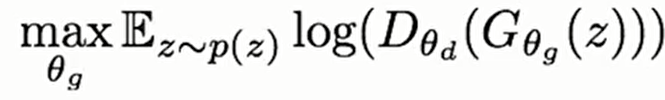

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define Optimizer

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Training and save checkpoints

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [48]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
label_seed = np.random.randint(0, 10, num_examples_to_generate)

قسمت اصلی فرایند آموزش در اینجا تعریف می‌شود. در اینجا به اندازه  بچ‌سایز بردارهای تصادفی 100 بعدی ساخته شده و به شبکه مولد داده می‌شود. سپس ابتدا شبکه مولد آموزش می‌بیند و تصاویری با ابعاد مورد نظر ما تولید می‌کنند در حالیکه شبکه ممیز ثابت است. سپس شبکه مولد ثابت می‌شود و تصویر اصلی و جعلی هر رو به شبکه ممیز داده می‌شوند و این شبکه آموزش می‌بیند و با استفاده از خروجی‌هایی که از شبکه ممیز برای تصاویر اصلی و جعلی به دست می‌آوریم مقدار تابع ضرر را برای هر دو شبکه به دست آورده و گرادیان پارامترهای هر دو شبکه را محاسبه کرده و آن‌ها را آپدیت می‌کنیم تا فرایند بهینه‌سازی در دو شبکه انجام شود

In [49]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    fake_labels = np.random.randint(0, 10, BATCH_SIZE)
    print(labels.shape)
    print(fake_labels.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, fake_labels], training=True)
      
      real_output = discriminator([images, labels], training=True)

      fake_output = discriminator([generated_images, fake_labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [51]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      
      train_step(image_batch, label_batch)
      # print('salam1', epoch)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, label_seed])

    
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           [seed, label_seed])

In [52]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

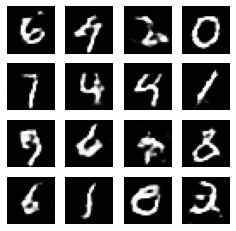

In [53]:
train(train_dataset, EPOCHS)

at the end save the generator model upload in lms

In [54]:
generator.save('generator.h5')